# Major League Baseball Strength of Schedule

The 2025 MLB season began on March 25th in Tokyo, Japan when the Chicago Cubs played the defending World Series champions the Los Angeles Dodgers. Starting the season against the defending champs can be a tall task, and unfortunately for Cubs their schedule was expected to continue to be tough well into April and May. The Cubs opponents were a common talking point during Cubs broadcasts. It was often stated that the Cubs had the hardest strength of schedule (SOS) to open the 2025 season. Every time the broadcast began talking on SOS, I would ask myself a few questions: 
1. How is strengh of schedule measured
2. How much harder is the Cubs schedule than the rest of the leagues
3. How does the Cub's 2025 season compare to previous seasons

To answer these questions began by gathering data by scraping data from Baseball-Reference. This process is included in the .py files in the scripts folder. Using the scraped data, I performed the following analysis comprising of the following section:
- Data Exploration and Summary
- Merging of Data Tables and Column Definition
- Findings and Visualizations


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_game_data = pd.read_csv("./clean_data/game_results.csv").drop(columns=['H/A', 'win_loss', 'game_time', 'day_night', 'attendance','game_length',])
df_season_data = pd.read_csv("./clean_data/season_results.csv").fillna({'teams': 'LAA'})

## Description of Data

This analysis consists of two main data tables:
1. df_game_data: Contains full season data for each game played in the Major Leagues. Contains data for the 2015-2025 seasons for a total of over 46,000 records
2. df_season_data: contains season summary for each MLB team for a total of 10 full seasons going back the 2015 season

In [2]:
print(f'Records included in df_game_data: {df_game_data.shape[1]}')
print(f'Seasons included in df_game_data: {min(df_game_data["season"])} - {max(df_game_data["season"])}')


print(f'\nRecords included in df_season_data: {df_season_data.shape[1]}')
print(f'Seasons included in df_season_data: {min(df_season_data["season"])} - {max(df_season_data["season"])}')

Records included in df_game_data: 7
Seasons included in df_game_data: 2015 - 2025

Records included in df_season_data: 7
Seasons included in df_season_data: 2015 - 2025


# Merging Data and Column Definitions

To compare strength of schedules, I need to combine the to dataframes but first some basic feature engineering and additional data cleaning was needed. Each teams' `run_differential` was caluculated for each season and was then added back into the `df_season_data`. This column will be used as one metric to measure a teams strength of schedule.

In [3]:
df_season_run_differential= (df_game_data
                             .assign(run_differential = df_game_data['runs_scored']-df_game_data['runs_allowed'])
                            .groupby(['team', 'season'])
                            .agg('sum')
                            .drop(columns='game_number')
                            .reset_index()
                            .replace({'team': 'OAK'}, 'ATH')
                            )

#adding the run scored, allowed, and differential to the season data
df_season_data = pd.merge(df_season_data, df_season_run_differential, left_on=['teams', 'season'], right_on=['team', 'season']).drop(columns=['team'])


Next, I added a columns to the `df_game_data` dataframe to measure the opponents winning percentage and run differential. For each game the intent is to bring in the opponent's winning percentage and run differential from the previous season. This was done by merging the df_season_data and df_game_data on the opponents team abbreviation and the previous season.

In [4]:
#join data on team and year
# need to offset the season in the game data

df_game_data = df_game_data.assign(previous_season=lambda x: x.season-1) 

df_merge_data = (
    pd.merge(df_game_data, df_season_data.loc[:, ['teams', 'season', 'win_%', 'run_differential']], how='left', left_on=['opponent', 'previous_season'], right_on=['teams', 'season'])
    .dropna(subset=['teams'])
    .drop(columns=['season_y','previous_season', 'teams'])
    .rename(columns={'win_%': 'opponent_win%', 'season_x': 'season', 'run_differential': 'opponent_run_differential'})
)
#6214 records => good

df_merge_data.head()

,date,team,opponent,runs_scored,runs_allowed,game_number,season,opponent_win%,opponent_run_differential
4858,2016-04-04,ARI,COL,5,10,1,2016,0.420,-107.0
4859,2016-04-05,ARI,COL,11,6,2,2016,0.420,-107.0
4860,2016-04-06,ARI,COL,3,4,3,2016,0.420,-107.0
4861,2016-04-07,ARI,CHC,6,14,4,2016,0.599,81.0
4862,2016-04-08,ARI,CHC,3,2,5,2016,0.599,81.0


The merged data then needed to aggregated to. Since this analysis is concered with the toughest start to a season, only the first 40 games of each team's schedule are retained in the data. 

In [5]:
df_merge_data = (df_merge_data
 .loc[df_merge_data['game_number']<=40]
 .groupby(['team', 'season'])
 .agg(
     runs_scored = ('runs_scored', 'sum'),
     runs_allowed = ('runs_allowed', 'sum'),
     opponent_win= ('opponent_win%', 'mean'),
     opponent_run_differential = ('opponent_run_differential', 'mean'),
    )
.round(4)
.reset_index()
#.columns(['team', 'season','runs_scored', 'runs_allowed', 'opponent_win%', 'opponent_run_differential'])
.sort_values(by ='opponent_win', ascending=False)
)

df_merge_data['opponent_win%_rank'] = df_merge_data['opponent_win'].rank(method='min', ascending=False)
df_merge_data['opponent_run_differential_rank'] = df_merge_data['opponent_run_differential'].rank(method='min', ascending=False)
df_merge_data = df_merge_data.assign(average_rank = (df_merge_data['opponent_run_differential_rank'] + df_merge_data['opponent_win%_rank']) / 2)



The following output shows that the Cubs have the toughest strength of schedule for the first 40 games when measured by their opponents previous year run differential and win percentage. I'm glad the broadcast crew wasn't lying to me!

In [6]:
print('Toughest Shedule by Opponent Win Percentage')
print(df_merge_data.loc[df_merge_data['season']==2025, ['team', 'opponent_win']].sort_values('opponent_win', ascending=False).head(5))

print('\nToughest Shedule by Opponent Run differential')
print(df_merge_data.loc[df_merge_data['season']==2025, ['team', 'opponent_run_differential']].sort_values('opponent_run_differential', ascending=False).head(5))

Toughest Shedule by Opponent Win Percentage
    team  opponent_win
50   CHC        0.5428
9    ARI        0.5298
90   COL        0.5262
289  TOR        0.5223
269  TBR        0.5199

Toughest Shedule by Opponent Run differential
    team  opponent_run_differential
50   CHC                     61.125
9    ARI                     50.050
289  TOR                     41.125
90   COL                     39.600
269  TBR                     32.625


I already determined the Cubs had the hardest opening schedule of 2025, but how does their SOS stack up to previous years? 

If I include results from years prior to 2025, it's apparent that while the Cub's 2025 opening schedule is tough it's no unprecedented. There have actually been handful of teams that have had tougher opening streches when comparing using the run differential and win percentage metrics.

In [7]:
print('Toughest Shedule by Opponent Win Percentage')
print(df_merge_data.loc[:, ['team', 'opponent_win']].sort_values('opponent_win', ascending=False).head(10))

print('\nToughest Shedule by Opponent Run differential')
print(df_merge_data.loc[:, ['team', 'opponent_run_differential']].sort_values('opponent_run_differential', ascending=False).head(10))


Toughest Shedule by Opponent Win Percentage
    team  opponent_win
189  NYY        0.5497
98   DET        0.5482
286  TOR        0.5468
2    ARI        0.5454
156  MIL        0.5453
201  PHI        0.5449
50   CHC        0.5428
273  TEX        0.5394
122  LAA        0.5389
298  WSN        0.5374

Toughest Shedule by Opponent Run differential
    team  opponent_run_differential
244  SFG                    66.7838
201  PHI                    65.8750
189  NYY                    64.8333
2    ARI                    63.3000
273  TEX                    62.0000
50   CHC                    61.1250
154  MIL                    58.7750
98   DET                    56.4500
286  TOR                    56.0811
236  SEA                    55.0500


Looking at the historic distribution of both metrics makes clear that the Cubs 2025 opening schedule is one of the toughest in recent years and is far harder than the average opening schedule.

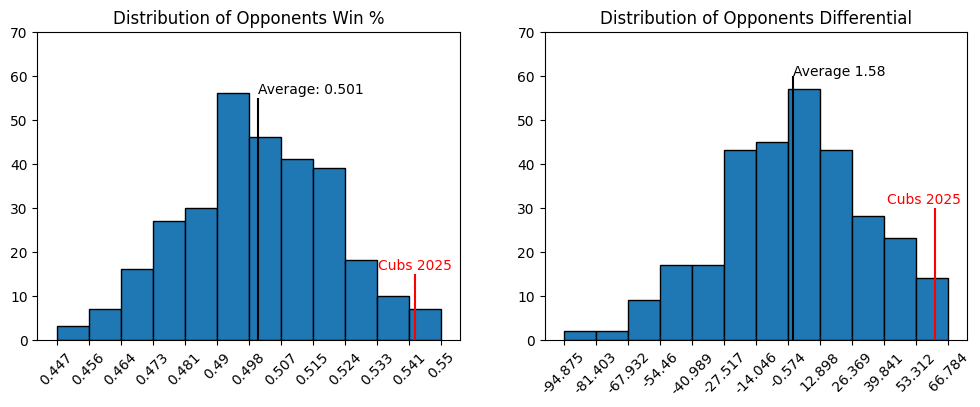

In [8]:
records = df_merge_data['opponent_win'].shape
cubs_2025 = df_merge_data.loc[(df_merge_data['team']=='CHC') & (df_merge_data['season']==2025), ['opponent_win', 'opponent_run_differential','opponent_run_differential_rank', 'opponent_win%_rank']]


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

#first plot: Win %
counts, bins  = np.histogram(df_merge_data.loc[:, 'opponent_win'], bins=12)
avg_opp_win = np.average( df_merge_data['opponent_win'])
ax1.hist(df_merge_data['opponent_win'], bins=12, edgecolor='black')
ax1.set_xticks(ticks=bins, labels=bins.round(3), rotation=45)
ax1.vlines(x=avg_opp_win, ymin=0, ymax=55, colors='black')
ax1.text(x=avg_opp_win, y=56, s=f'Average: {avg_opp_win.round(3)}')
ax1.set_ylim(ymin=0, ymax=round(max(counts)+10, -1))
ax1.set_title('Distribution of Opponents Win %')

ax1.vlines(x=cubs_2025['opponent_win'], ymin=0, ymax=15, colors='red')
ax1.text(x=cubs_2025['opponent_win']-.01, y=16, s='Cubs 2025', c='red')

#second plot: Run Differential
counts, bins  = np.histogram(df_merge_data.loc[:, 'opponent_run_differential'], bins=12)
avg_opp_runs_diff = np.average( df_merge_data['opponent_run_differential'])
ax2.hist(df_merge_data['opponent_run_differential'], bins=12, edgecolor='black')
ax2.set_xticks(ticks=bins, labels=bins.round(3), rotation=45)
ax2.vlines(x=avg_opp_runs_diff, ymin=0, ymax=60, colors='black')
ax2.text(x=avg_opp_runs_diff, y=60, s=f'Average {avg_opp_runs_diff.round(2)}')
ax2.set_ylim(ymin=0, ymax=round(max(counts)+10, -1))
ax2.set_title('Distribution of Opponents Differential')

ax2.vlines(x=cubs_2025['opponent_run_differential'], ymin=0, ymax=30, colors='red')
ax2.text(x=cubs_2025['opponent_run_differential']-20, y=31, s='Cubs 2025', c='red')

plt.plot();

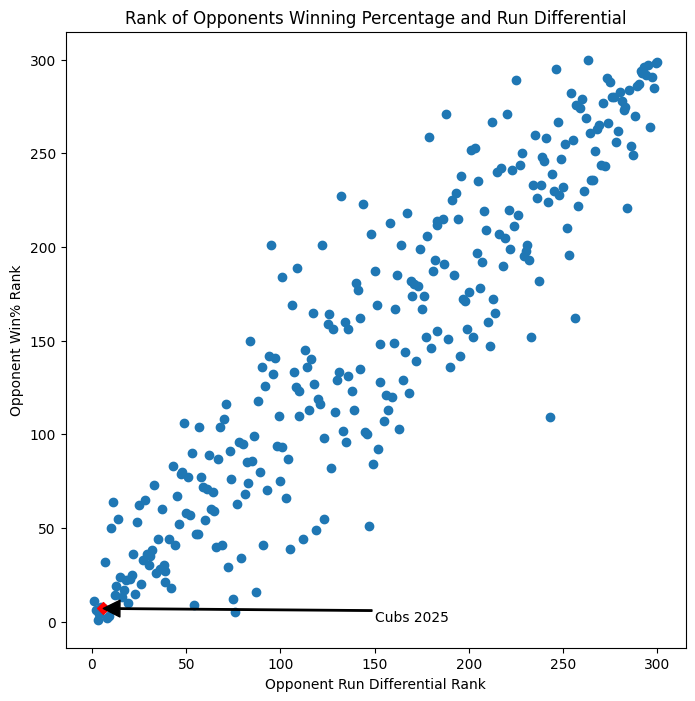

In [9]:

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))


x_data = df_merge_data['opponent_run_differential_rank']
y_data = df_merge_data['opponent_win%_rank']

ax.scatter(x=x_data, y=y_data)
ax.set_xlabel(xlabel = 'Opponent Run Differential Rank')
ax.set_ylabel(ylabel = "Opponent Win% Rank")

#Cubs Callout
ax.scatter(x=cubs_2025['opponent_run_differential_rank'], y=cubs_2025['opponent_win%_rank'], c='red', marker='D')
ax.annotate(text='Cubs 2025', xy=(cubs_2025['opponent_run_differential_rank'], cubs_2025['opponent_win%_rank']), xytext=(150, 0),arrowprops=dict(facecolor='black', width=1))


ax.set_title('Rank of Opponents Winning Percentage and Run Differential')

plt.plot();
